# Plot the top 25 Twitter Hashtags from the day of 10/13 Democratic Debate and the 10/28 Republican Debate

Connect to Neo4j instance using the [Py2neo Python Library v3](http://py2neo.org/3/)

In [1]:
from py2neo import Graph, authenticate

authenticate("192.168.1.1:7474", "neo4j", "xxxx")
graph = Graph("bolt://192.168.1.1/db/data/")

Define the time boundaries for the Democratic and Republican Debates

In [2]:
from datetime import datetime

# Twitter uses the UNIX timestamp for the timestamp_ms field, covert the datetime object to the UNIX timestamp format
dem_debate_start = datetime(2015, 10, 13, 0, 0)
dem_debate_start_ts = int(dem_debate_start.strftime("%s")) * 1000

dem_debate_end = datetime(2015, 10, 14, 0, 0)
dem_debate_end_ts = int(dem_debate_end.strftime("%s")) * 1000

rep_debate_start = datetime(2015, 10, 28, 0, 0)
rep_debate_start_ts = int(rep_debate_start.strftime("%s")) * 1000

rep_debate_end = datetime(2015, 10, 29, 0, 0)
rep_debate_end_ts = int(rep_debate_end.strftime("%s")) * 1000

Count the number of tweets in Neo4j for the Democratic Debate

In [3]:
query = """
MATCH (t:Tweet)
WHERE toFloat(t.timestamp_ms) > toFloat(%s) AND toFloat(t.timestamp_ms) < toFloat(%s) 
RETURN COUNT(t)
"""

final_query = query % (dem_debate_start_ts, dem_debate_end_ts)

num_dem_tweets = graph.run(final_query)
num_dem_tweets.dump()

 COUNT(t) 
----------
 1006263  


Count the number of tweets in Neo4j for the Republican Debate

In [4]:
query = """
MATCH (t:Tweet)
WHERE toFloat(t.timestamp_ms) > toFloat(%s) AND toFloat(t.timestamp_ms) < toFloat(%s) 
RETURN COUNT(t)
"""

final_query = query % (rep_debate_start_ts, rep_debate_end_ts)

num_rep_tweets = graph.run(final_query)
num_rep_tweets.dump()

 COUNT(t) 
----------
 1588026  


Find the top 25 Democratic Debate hashtags and import the results into a [Pandas](http://pandas.pydata.org/) DataFrame.

In [5]:
import pandas 

query = """
MATCH (h:Hashtag)-[:TAGS]->(t:Tweet)   
WHERE toFloat(t.timestamp_ms) > toFloat(%s) AND toFloat(t.timestamp_ms) < toFloat(%s) 
RETURN h.name AS hashtag, COUNT(t) AS tweets 
ORDER BY tweets DESC LIMIT 25
"""

final_query = query % (dem_debate_start_ts, dem_debate_end_ts)

top_dem_hashtags = graph.run(final_query)

top_dem_hashtags_df = pandas.DataFrame(top_dem_hashtags.__iter__(), columns=top_dem_hashtags.keys())
top_dem_hashtags_df

,hashtag,tweets
0,demdebate,209478
1,debatewithbernie,39550
2,feelthebern,18775
3,cnndebate,15952
4,health,14906
5,democraticdebate,12112
6,imwithher,10818
7,tcot,10293
8,trump2016,8834
9,berniesanders,7918


Find the top 25 Republican Debate hashtags and import the results into a [Pandas](http://pandas.pydata.org/) DataFrame.

In [6]:
query = """
MATCH (h:Hashtag)-[:TAGS]->(t:Tweet)   
WHERE toFloat(t.timestamp_ms) > toFloat(%s) AND toFloat(t.timestamp_ms) < toFloat(%s) 
RETURN h.name AS hashtag, COUNT(t) AS tweets 
ORDER BY tweets DESC LIMIT 25
"""

final_query = query % (rep_debate_start_ts, rep_debate_end_ts)

top_rep_hashtags = graph.run(final_query)

top_rep_hashtags_df = pandas.DataFrame(top_rep_hashtags.__iter__(), columns=top_rep_hashtags.keys())
top_rep_hashtags_df

,hashtag,tweets
0,gopdebate,189132
1,cnbcgopdebate,82639
2,health,39209
3,tcot,23761
4,trump,19343
5,gop,18220
6,cruzcrew,17878
7,trump2016,13896
8,pjnet,13419
9,uniteblue,10005


Plot the top 25 hashtags from both debate ordered by the number of times they appear in a tweet

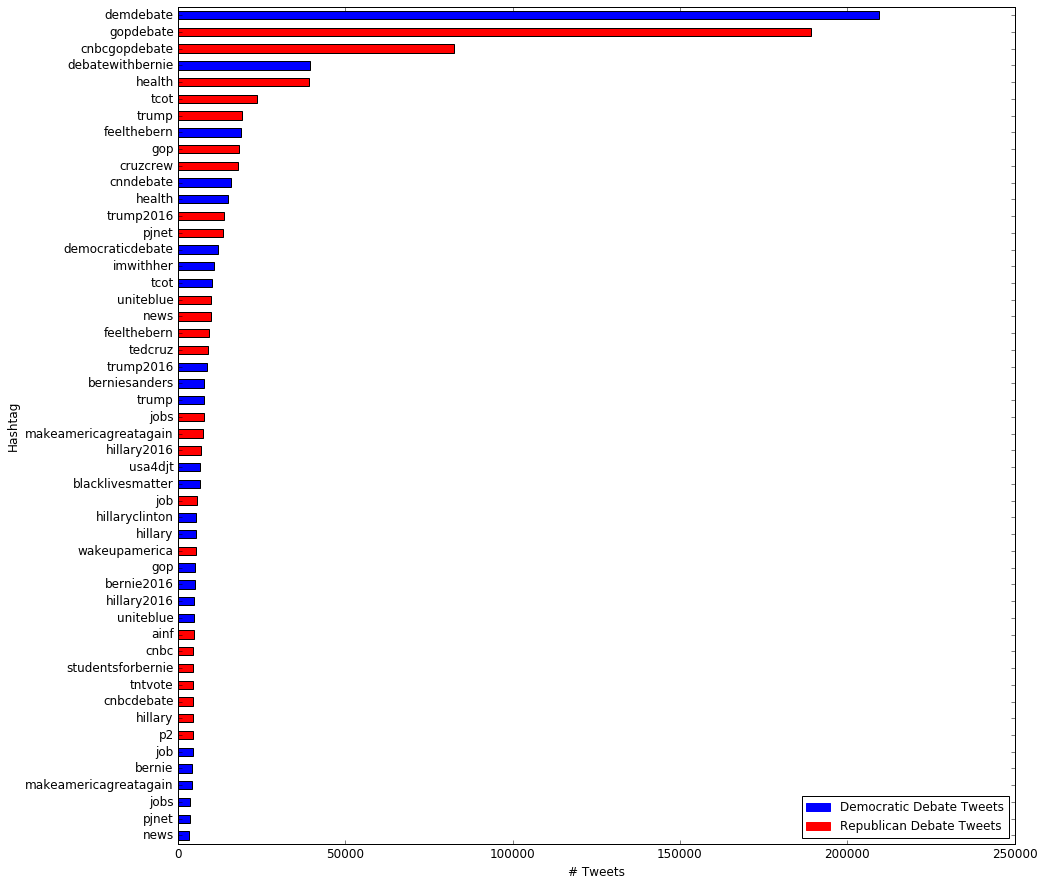

In [7]:
%matplotlib inline

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Combine the top_dem_hashtags_df dataframe with the top_rep_hashtags_df dataframe and create a color column based
# on which dataframe the hashtag came from
result = pandas.concat([top_dem_hashtags_df, top_rep_hashtags_df], keys=["blue", "red"])
# Sort the dataframe based on the number of tweets
final = result.sort_values(by="tweets", ascending=True)
final = final.reset_index()

# Plot the combined dataframe
plt.figure()

ax = final.plot('hashtag', 'tweets', kind='barh', color=final["level_0"].tolist(), figsize=(15,15), legend=True, fontsize=12)
#ax.set_xticklabels(final["tweets"])
ax.set_xlabel("# Tweets", fontsize=12)
ax.set_ylabel("Hashtag", fontsize=12)

legend_patches = [mpatches.Patch(color='blue', label='Democratic Debate Tweets'), 
                  mpatches.Patch(color='red', label='Republican Debate Tweets')]
plt.legend(handles=legend_patches, loc='lower right')

plt.show()